In [1]:
import sys
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SHAP
import shap

# RDKit
from rdkit.Chem.rdmolfiles import MolFromXYZFile, MolToXYZFile
from rdkit import Chem
from rdkit.Chem import rdDetermineBonds, MACCSkeys, AllChem

# DScribe
from dscribe.descriptors import ACSF, CoulombMatrix, MBTR, SOAP, CoulombMatrix
from dscribe.kernels import REMatchKernel
from ase.io import read
from sklearn.preprocessing import normalize


In [2]:
def xyz_to_cleanmol(path):
    '''
    Clean mol object from xyz 

    params
    ------
    path: str
        Path to structure

    fragment: str
        Options: A, B, AB
        
    returns
    -------
    mol: rdkit.Chem.rdchem.Mol
        Cleaned mol object
    '''

    mol=MolFromXYZFile(path)
    rdDetermineBonds.DetermineConnectivity(mol)
    Chem.SanitizeMol(mol)
    Chem.AssignStereochemistry(mol,cleanIt=True)
    Chem.Kekulize(mol)
    
    return mol

In [3]:
data={}
# Loop dirs and skip the .ipynb file
for dirs in os.listdir():
    if os.path.isdir(dirs) and '.ipynb' not in dirs:
        data[dirs]={}
        # Loop over radii
        for file in glob(os.path.join(dirs,'*/*.output')):
            molecule,radius=file.split('/')[0:2]
            data[dirs][radius]={}
            # Find energies!
            with open(file,'r') as f:
                for line in f.readlines():
                    if '::    Total SCF' in line:
                        scf=float(line.split()[-1])
                        data[dirs][radius]['SCF']=scf
                    if '::    Total MBPT2' in line:
                        MP2=float(line.split()[-1])
                        data[dirs][radius]['MP2']=MP2
                    if '::    RASSCF' in line:
                        CASSCF=float(line.split()[-1])
                        data[dirs][radius]['CASSCF']=CASSCF
                    if '::    CASPT2' in line:
                        CASPT2=float(line.split()[-1])
                        data[dirs][radius]['CASPT2']=CASPT2
        # Loop over xyz
        for file in glob(os.path.join(dirs,'*/*.xyz')):
            molecule,radius=file.split('/')[0:2]
            data[dirs][radius]['structures']={'ASE':read(file),'mol':xyz_to_cleanmol(file)}

In [4]:
with open("diatomics.txt") as f:
    diatomics=[i.strip('\n').split('_') for i in f.readlines()]

In [5]:
all_species=set(sum(diatomics,[]))

In [6]:
Morgan={}
RDKit={}
MACCS={}

fpgen = AllChem.GetRDKitFPGenerator()
Morgangen = AllChem.GetMorganGenerator(radius=2)
for k,v in data.items():
    Morgan[k]={}
    RDKit[k]={}
    MACCS[k]={}
    for k1,v1 in v.items():
        mol=v1['structures']['mol']
        
        MACCS[k][k1]=list(MACCSkeys.GenMACCSKeys(mol))
        RDKit[k][k1]=list(fpgen.GetFingerprint(mol))
        Morgan[k][k1]=list(Morgangen.GetFingerprint(mol))

In [7]:
# Initialize dscribe feature parameters


# Set up the SOAP descriptor with parameters:
# species, rcut, nmax, and lmax
soap = SOAP(species=all_species,r_cut=3,n_max=4,l_max=3,sigma=1.5,periodic=False)
re = REMatchKernel(metric="rbf", gamma=2, alpha=1.2, threshold=1e-8, normalize_kernel=False)

# Setting up the CM descriptor
cm = CoulombMatrix(n_atoms_max=2,permutation='eigenspectrum',seed=42)

In [8]:
ordering=sum([[(k,k1) for k1,v1 in v.items()] for k,v in data.items()],[])
flattened_ASE=sum([[v1['structures']['ASE'] for k1,v1 in v.items()]for k,v in data.items()],[])
flattened_mol=sum([[v1['structures']['mol'] for k1,v1 in v.items()]for k,v in data.items()],[])

In [9]:
MACCS_mol=[list(MACCSkeys.GenMACCSKeys(mol)) for mol in flattened_mol]
RDKit_mol=[list(fpgen.GetFingerprint(mol)) for mol in flattened_mol]
Morgan_mol=[list(Morgangen.GetFingerprint(mol)) for mol in flattened_mol]
cm_mol = cm.create(flattened_ASE)
soap_mol = re.create([normalize(i) for i in soap.create(flattened_ASE)])

In [10]:
MACCS_df=pd.DataFrame(MACCS_mol)
MACCS_df[['molecule','radius']]=ordering
MACCS_df=MACCS_df.set_index(['molecule','radius'])

In [11]:
RDKit_df=pd.DataFrame(RDKit_mol)
RDKit_df[['molecule','radius']]=ordering
RDKit_df=RDKit_df.set_index(['molecule','radius'])


In [12]:
Morgan_df=pd.DataFrame(Morgan_mol)
Morgan_df[['molecule','radius']]=ordering
Morgan_df=Morgan_df.set_index(['molecule','radius'])


In [13]:
soap_df=pd.DataFrame(soap_mol)
soap_df[['molecule','radius']]=ordering
soap_df=soap_df.set_index(['molecule','radius'])

In [14]:
cm_df=pd.DataFrame(cm_mol)
cm_df[['molecule','radius']]=ordering
cm_df=cm_df.set_index(['molecule','radius'])


In [15]:
ydata=[]
for k,v in data.items():
    df=pd.DataFrame.from_dict({k1:{k2:v2 for k2,v2 in v1.items() if k2!='structures'} for k1,v1 in v.items()}).T.reset_index()
    df['mol']=len(df)*[k]
    df=df.set_index(['mol','index'])
    ydata.append(df)
df_y=pd.concat(ydata)

In [16]:
df_y.loc['HLi'].sort_index().idxmin()

SCF       1.70
MP2       1.70
CASSCF    1.70
CASPT2    1.70
dtype: object

<Axes: xlabel='index'>

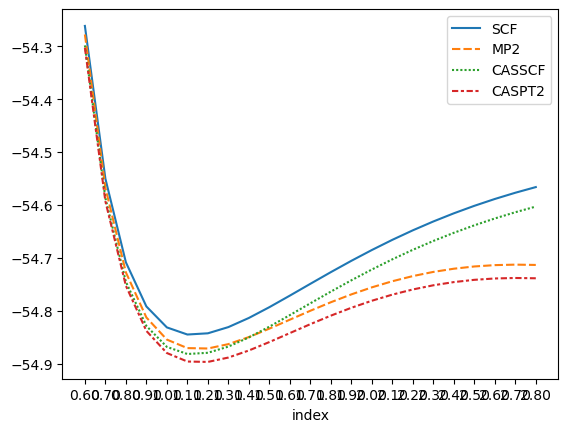

In [32]:
sns.lineplot(data=df_y.loc['HN'].sort_index())
# plt.ylim(-39.25,-39)

<Axes: xlabel='index', ylabel='CASPT2'>

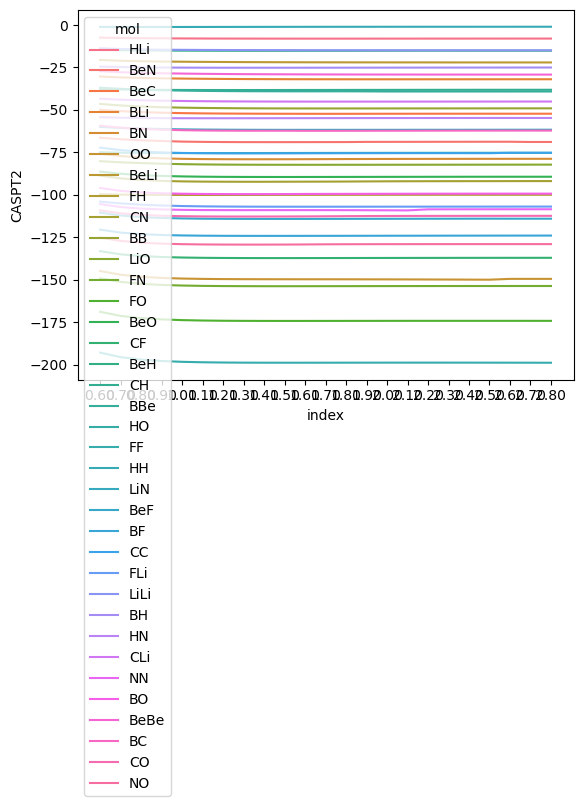

In [18]:
sns.lineplot(data=df_y.reset_index().sort_values(by='index'),x='index',hue='mol',y='CASPT2')